## Set up environment

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.options.display.float_format = "{:,.4f}".format
plt.style.use('ggplot')

# Import our utilities
from data_loader import DGADataLoader
from model_utils import DGAModelEvaluator  
from plot_utils import DGAPlotter

# ML imports
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, StratifiedKFold, train_test_split

np.random.seed(41)

## Initialize Utilities and Load Data


In [2]:
# Initialize utilities
data_loader = DGADataLoader()
model_evaluator = DGAModelEvaluator()
plotter = DGAPlotter()

# Load all datasets
datasets = data_loader.load_all_datasets()

# Extract individual datasets
tc10_data = datasets['tc10']['data']
tc10_labels = datasets['tc10']['labels']
mirowski_data = datasets['mirowski']['data'] 
mirowski_labels = datasets['mirowski']['labels']
hk_data = datasets['hk']['data']
hk_labels = datasets['hk']['labels']
smote_data = datasets['smote']['data']
smote_labels = datasets['smote']['labels']

print("Datasets loaded:")
for name, dataset in datasets.items():
    print(f"- {dataset['name']}: {dataset['data'].shape[0]} samples, {dataset['data'].shape[1]} features")

Datasets loaded:
- TC 10: 167 samples, 7 features
- Mirowski: 233 samples, 7 features
- Hong Kong: 424 samples, 7 features
- SMOTE: 234 samples, 7 features


## Dataset Visualization Function

In [3]:
def plot_datasets(X, y, title=''):
    """Plot 3D views of datasets"""
    axis_labels = X.columns
    X_transformed = data_loader.get_transformed_data(X)
    
    fig = plt.figure(figsize=(15,5), dpi=300)
    fig.suptitle(title, size='xx-large')
    
    # Plot different feature combinations
    plotter.plot_3d_dataset(X_transformed[[0, 5, 6]], y, axis_labels[[0, 5, 6]], fig, (1,3,1))
    plt.legend()
    plotter.plot_3d_dataset(X_transformed[[2, 3, 4]], y, axis_labels[[2, 3, 4]], fig, (1,3,2))
    plotter.plot_3d_dataset(X_transformed[[0, 1, 3]], y, axis_labels[[0, 1, 3]], fig, (1,3,3))
    
    plt.tight_layout()
    plt.show()
    plt.close()

## Visualize TC10 and Hong Kong Datasets

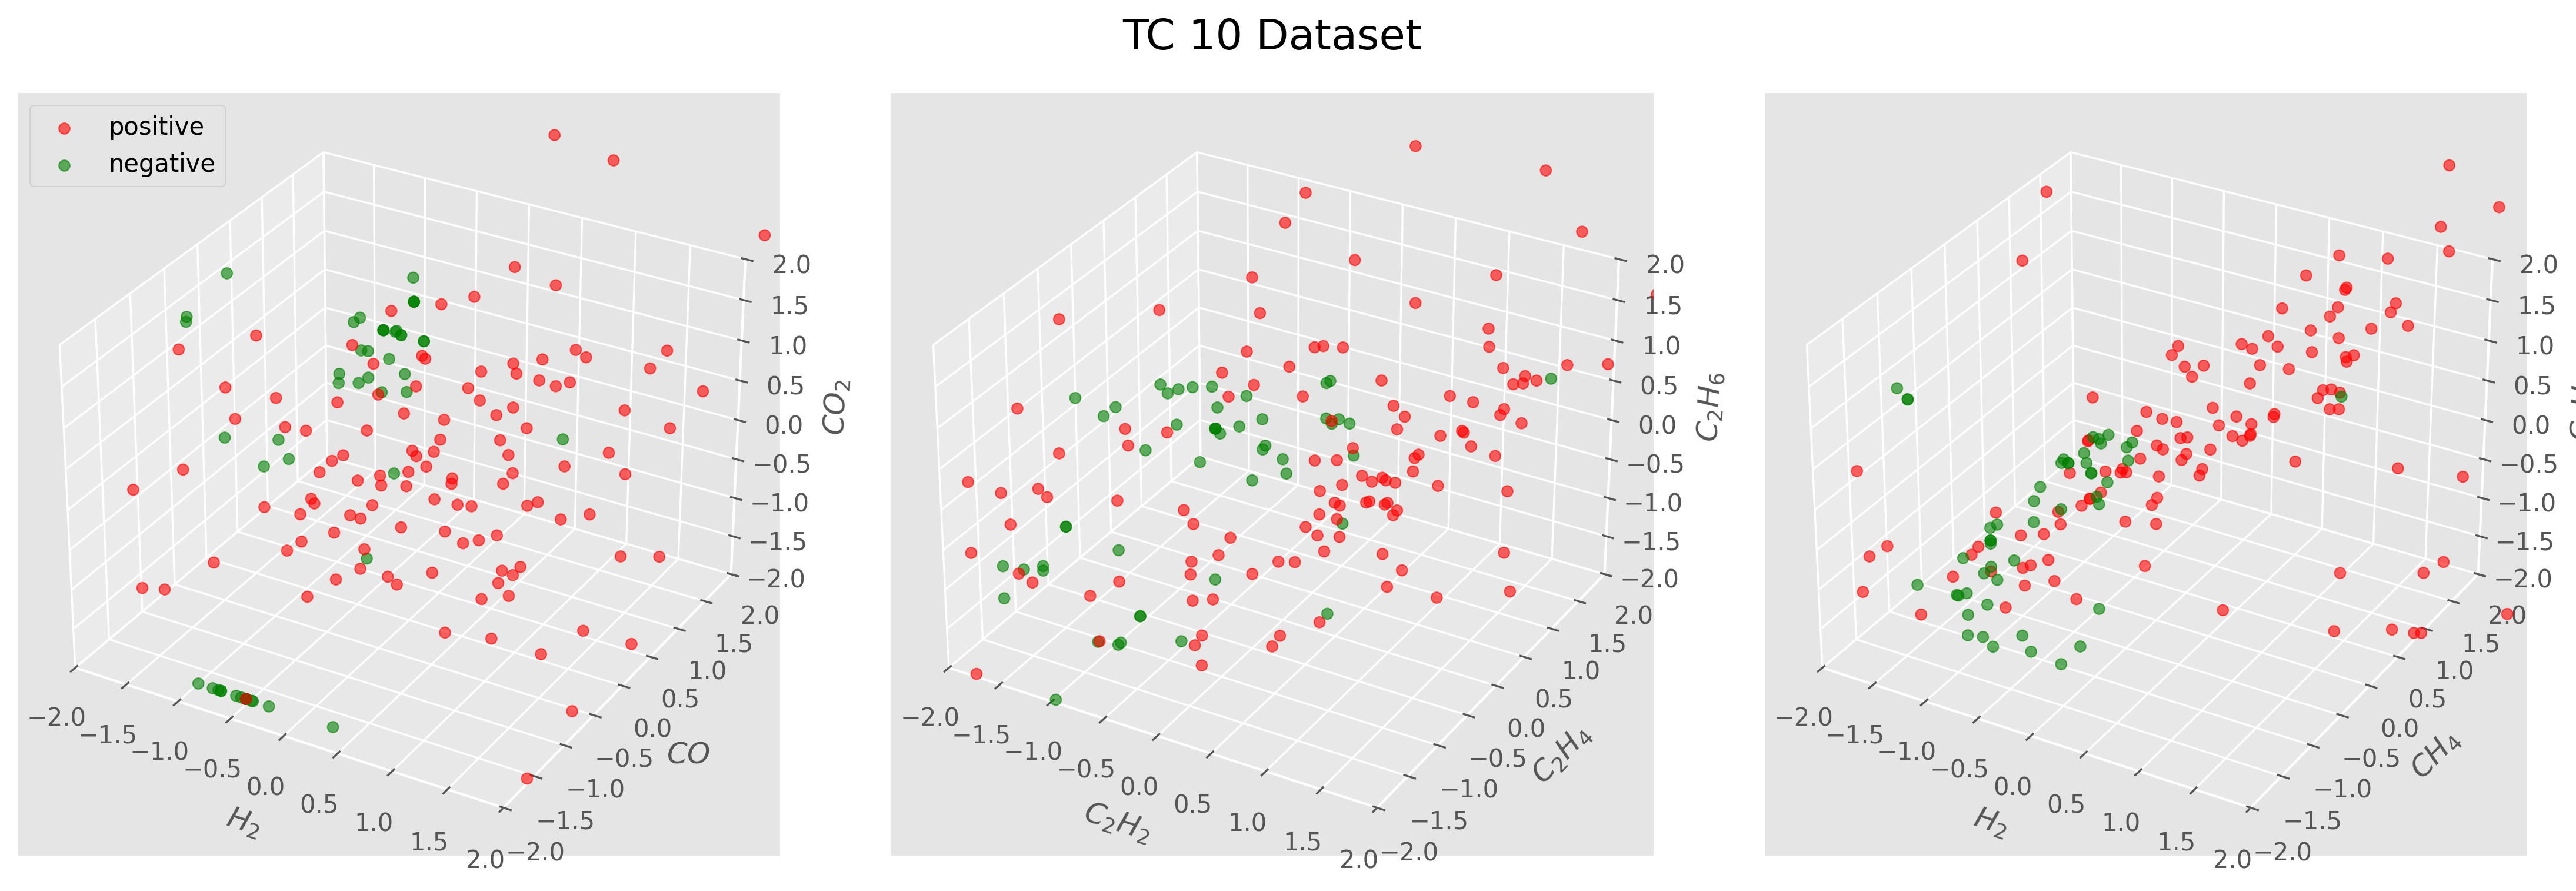

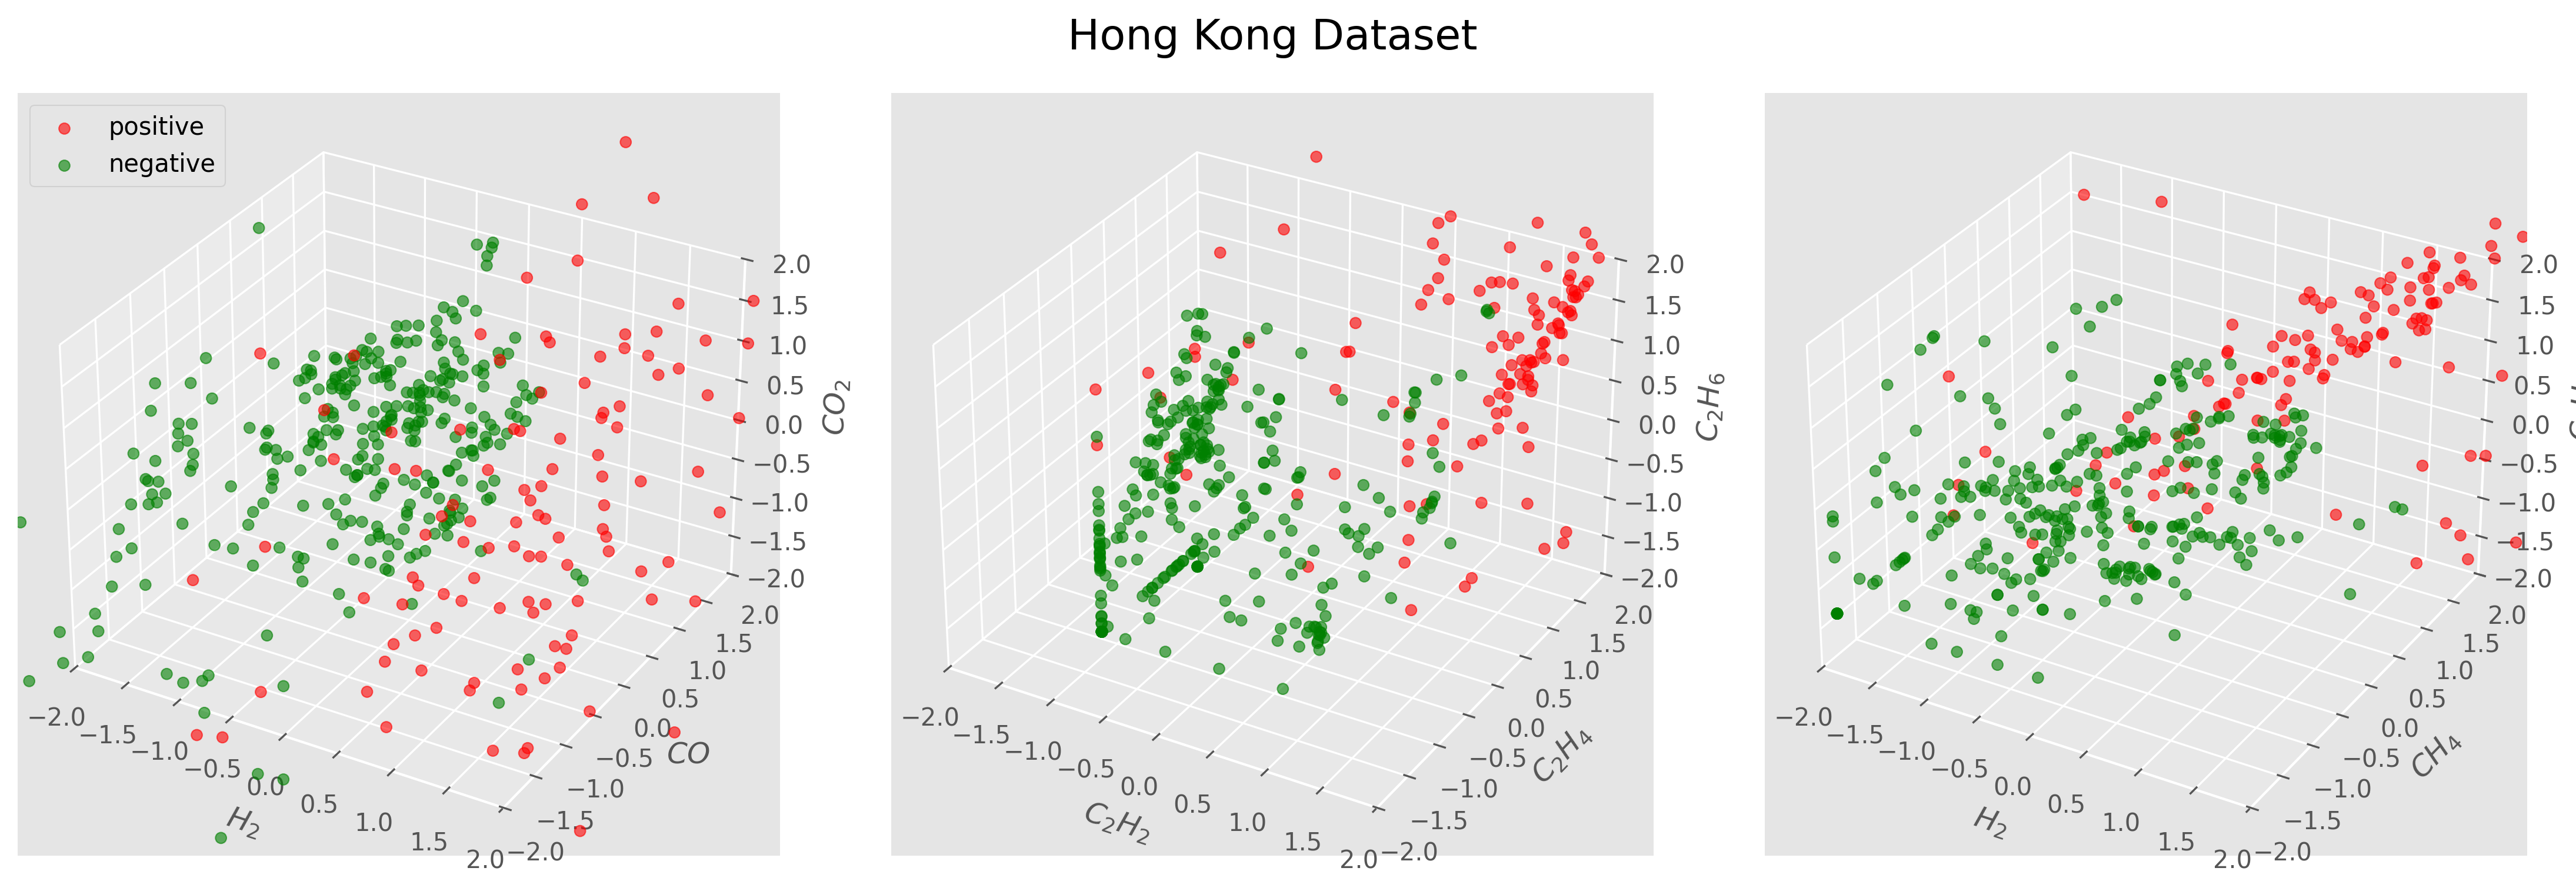

In [4]:
plot_datasets(tc10_data, tc10_labels, title='TC 10 Dataset')
plot_datasets(hk_data, hk_labels, title='Hong Kong Dataset')

## Compare SMOTE and Reweighting

,Architecture,Dataset,Preprocessing,Accuracy,ROC AUC,Precision,Recall,PR AUC,F1 Score
0,SVC (rbf),"TC 10, imbalanced",Y–J transformation,0.8854,0.9330,0.9373,0.8967,0.9677,0.9157
1,SVC (rbf),"TC 10, balanced",Y–J transformation,0.8854,0.9574,0.9784,0.8533,0.9815,0.9100
2,SVC (rbf),SMOTE,Y–J transformation,0.9142,0.9750,0.9709,0.8533,0.9740,0.9061


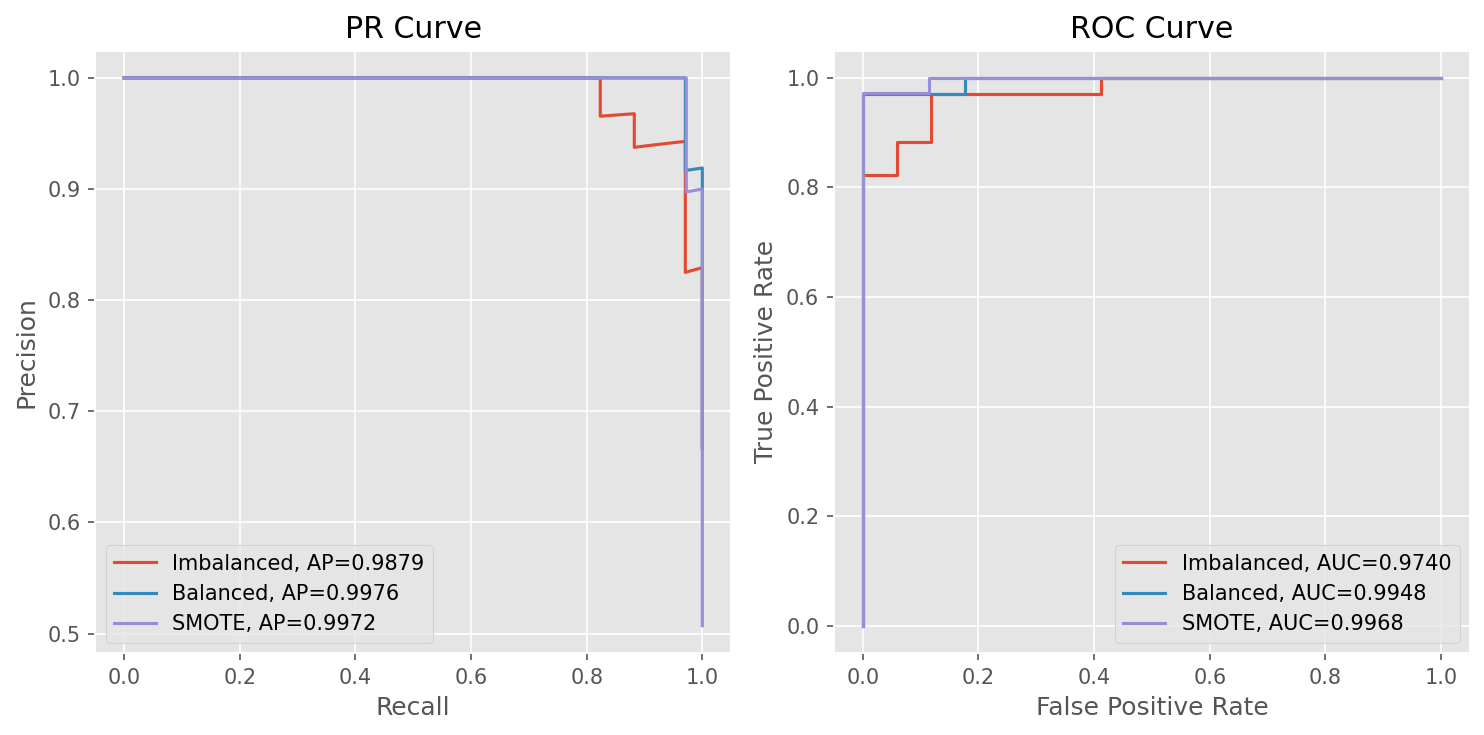

In [5]:
# Define checkpoints for SMOTE comparison
checkpoints = [
    {
        'data': tc10_data,
        'labels': tc10_labels,
        'architecture': 'SVC (rbf)',
        'dataset': 'TC 10, imbalanced',
        'preprocessing': 'Y–J transformation',
        'pipeline': Pipeline([
            ('yj_transform', PowerTransformer()),
            ('svc', SVC(kernel='rbf', probability=True, random_state=41))
        ]),
        'legend': 'Imbalanced'
    },
    {
        'data': tc10_data,
        'labels': tc10_labels,
        'architecture': 'SVC (rbf)',
        'dataset': 'TC 10, balanced',
        'preprocessing': 'Y–J transformation',
        'pipeline': Pipeline([
            ('yj_transform', PowerTransformer()),
            ('svc', SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=41))
        ]),
        'legend': 'Balanced'
    },
    {
        'data': smote_data,
        'labels': smote_labels,
        'architecture': 'SVC (rbf)',
        'dataset': 'SMOTE',
        'preprocessing': 'Y–J transformation',
        'pipeline': Pipeline([
            ('yj_transform', PowerTransformer()),
            ('svc', SVC(kernel='rbf', probability=True, random_state=41))
        ]),
        'legend': 'SMOTE'
    },
]

# Evaluate and display results
results_list = model_evaluator.evaluate_models(checkpoints)
display(pd.DataFrame(results_list))

# Plot curves
plotter.plot_pr_roc_curves(checkpoints)

## Compare Different Datasets

,Architecture,Dataset,Preprocessing,Accuracy,ROC AUC,Precision,Recall,PR AUC,F1 Score
0,SVC (rbf),TC 10,Y–J transformation,0.8854,0.9330,0.9373,0.8967,0.9677,0.9157
1,SVC (rbf),Mirowski,Y–J transformation,0.8584,0.9532,0.8861,0.8620,0.9644,0.8637
2,SVC (rbf),SMOTE,Y–J transformation,0.9142,0.9750,0.9709,0.8533,0.9740,0.9061
3,SVC (rbf),Hong Kong,Y–J transformation,0.9317,0.9607,0.9260,0.8460,0.9445,0.8785


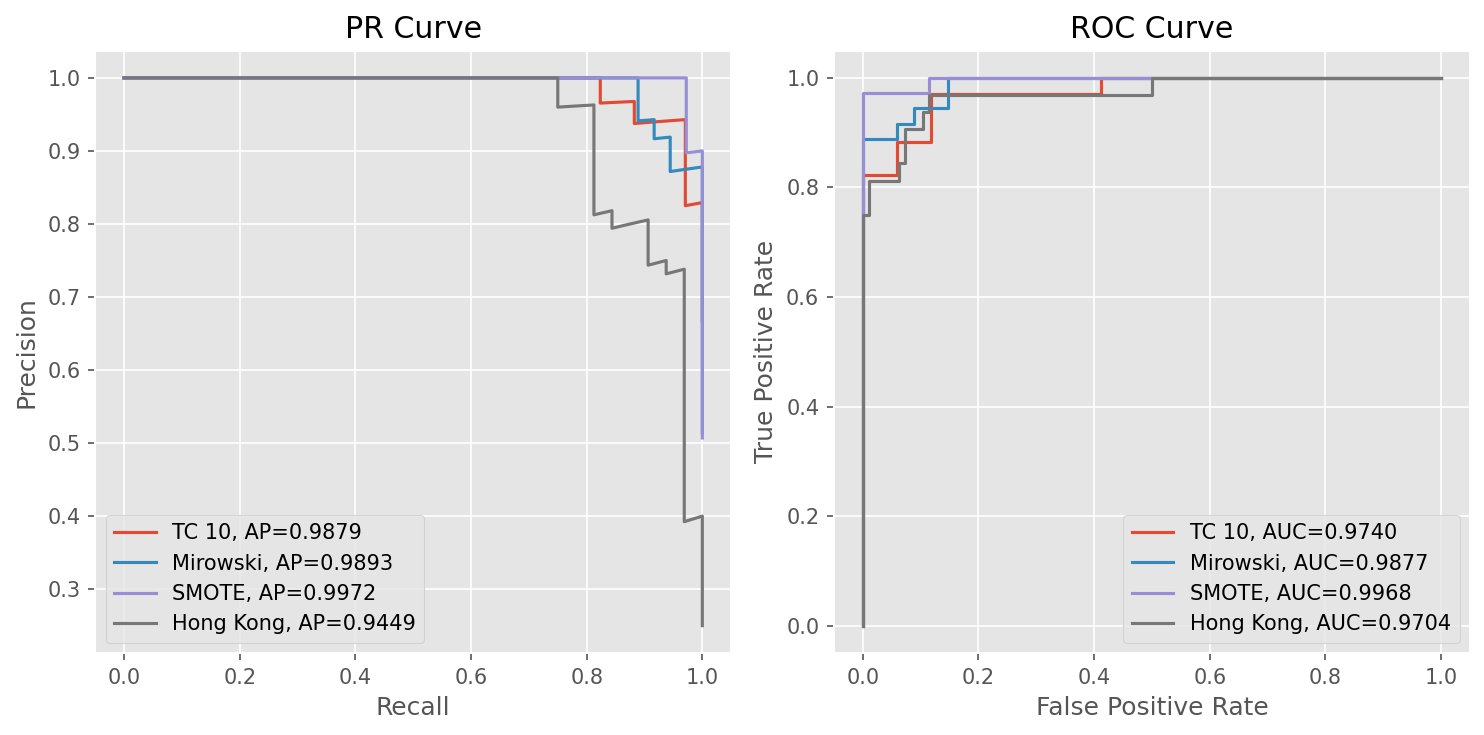

In [6]:
# Common pipeline for dataset comparison
pipeline_svc_rbf = Pipeline([
    ('yj_transform', PowerTransformer()),
    ('svc', SVC(kernel='rbf', probability=True, random_state=41))
])

checkpoints = [
    {
        'data': tc10_data,
        'labels': tc10_labels,
        'architecture': 'SVC (rbf)',
        'dataset': 'TC 10',
        'preprocessing': 'Y–J transformation',
        'pipeline': pipeline_svc_rbf,
        'legend': 'TC 10'
    },
    {
        'data': mirowski_data,
        'labels': mirowski_labels,
        'architecture': 'SVC (rbf)',
        'dataset': 'Mirowski',
        'preprocessing': 'Y–J transformation',
        'pipeline': pipeline_svc_rbf,
        'legend': 'Mirowski'
    },
    {
        'data': smote_data,
        'labels': smote_labels,
        'architecture': 'SVC (rbf)',
        'dataset': 'SMOTE',
        'preprocessing': 'Y–J transformation',
        'pipeline': pipeline_svc_rbf,
        'legend': 'SMOTE'
    },
    {
        'data': hk_data,
        'labels': hk_labels,
        'architecture': 'SVC (rbf)',
        'dataset': 'Hong Kong',
        'preprocessing': 'Y–J transformation',
        'pipeline': pipeline_svc_rbf,
        'legend': 'Hong Kong'
    }
]

# Evaluate and display results
results_list = model_evaluator.evaluate_models(checkpoints)
display(pd.DataFrame(results_list))

# Plot curves
plotter.plot_pr_roc_curves(checkpoints)

## Compare Different Models on TC10 Dataset

,Architecture,Dataset,Preprocessing,Accuracy,ROC AUC,Precision,Recall,PR AUC,F1 Score
0,kNN,TC 10,Y–J transformation,0.8670,0.9031,0.9391,0.8616,0.9501,0.8968
1,Random Forest,TC 10,Y–J transformation,0.9032,0.9462,0.9388,0.9221,0.9745,0.9296
2,SVC (linear),TC 10,Y–J transformation,0.7426,0.8039,0.8616,0.7525,0.9170,0.7972
3,SVC (poly),TC 10,Y–J transformation,0.7902,0.8892,0.7828,0.9739,0.9506,0.8669
4,SVC (rbf),TC 10,Y–J transformation,0.8854,0.9330,0.9373,0.8967,0.9677,0.9157
5,NN,TC 10,Y–J transformation,0.8913,0.9261,0.9298,0.9134,0.9686,0.9202


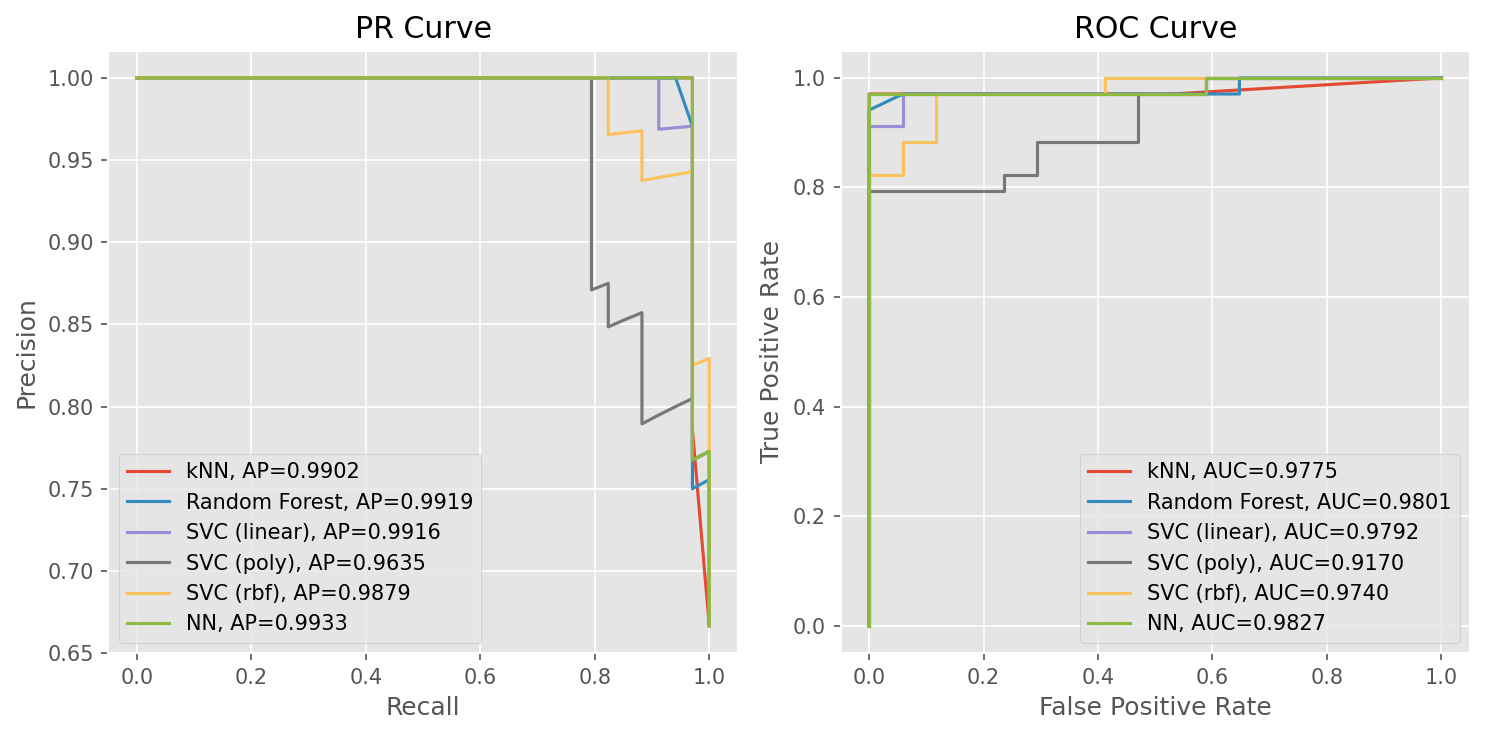

In [7]:
# Define checkpoints for different models on TC10
checkpoints = [
    {
        'data': tc10_data,
        'labels': tc10_labels,
        'architecture': 'kNN',
        'dataset': 'TC 10',
        'preprocessing': 'Y–J transformation',
        'pipeline': Pipeline([
            ('yj_transform', PowerTransformer()),
            ('knn', KNeighborsClassifier())
        ]),
        'legend': 'kNN'
    },
    {
        'data': tc10_data,
        'labels': tc10_labels,
        'architecture': 'Random Forest',
        'dataset': 'TC 10',
        'preprocessing': 'Y–J transformation',
        'pipeline': Pipeline([
            ('yj_transform', PowerTransformer()),
            ('rf', RandomForestClassifier(random_state=41))
        ]),
        'legend': 'Random Forest'
    },
    {
        'data': tc10_data,
        'labels': tc10_labels,
        'architecture': 'SVC (linear)',
        'dataset': 'TC 10',
        'preprocessing': 'Y–J transformation',
        'pipeline': Pipeline([
            ('yj_transform', PowerTransformer()),
            ('svc', SVC(kernel='linear', probability=True, random_state=41))
        ]),
        'legend': 'SVC (linear)'
    },
    {
        'data': tc10_data,
        'labels': tc10_labels,
        'architecture': 'SVC (poly)',
        'dataset': 'TC 10',
        'preprocessing': 'Y–J transformation',
        'pipeline': Pipeline([
            ('yj_transform', PowerTransformer()),
            ('svc', SVC(kernel='poly', probability=True, random_state=41))
        ]),
        'legend': 'SVC (poly)'
    },
    {
        'data': tc10_data,
        'labels': tc10_labels,
        'architecture': 'SVC (rbf)',
        'dataset': 'TC 10',
        'preprocessing': 'Y–J transformation',
        'pipeline': Pipeline([
            ('yj_transform', PowerTransformer()),
            ('svc', SVC(kernel='rbf', probability=True, random_state=41))
        ]),
        'legend': 'SVC (rbf)'
    },
    {
        'data': tc10_data,
        'labels': tc10_labels,
        'architecture': 'NN',
        'dataset': 'TC 10',
        'preprocessing': 'Y–J transformation',
        'pipeline': Pipeline([
            ('yj_transform', PowerTransformer()),
            ('nn', MLPClassifier(hidden_layer_sizes=(10,), activation='relu', solver='sgd', max_iter=10000, random_state=41))
        ]),
        'legend': 'NN'
    }
]

# Evaluate and display results
results_list = model_evaluator.evaluate_models(checkpoints)
display(pd.DataFrame(results_list))

# Plot curves
plotter.plot_pr_roc_curves(checkpoints)

## Compare Different Models on Hong Kong Dataset


,Architecture,Dataset,Preprocessing,Accuracy,ROC AUC,Precision,Recall,PR AUC,F1 Score
0,kNN,hk,Y–J transformation,0.9410,0.9450,0.9600,0.8290,0.9092,0.8877
1,Random Forest,hk,Y–J transformation,0.9317,0.9733,0.9273,0.8543,0.9518,0.8820
2,SVC (linear),hk,Y–J transformation,0.9152,0.9383,0.8850,0.8370,0.9153,0.8522
3,SVC (poly),hk,Y–J transformation,0.9316,0.9294,0.9895,0.7601,0.9247,0.8593
4,SVC (rbf),hk,Y–J transformation,0.9317,0.9607,0.9260,0.8460,0.9445,0.8785
5,NN,hk,Y–J transformation,0.9081,0.9484,0.8623,0.8457,0.9256,0.8461


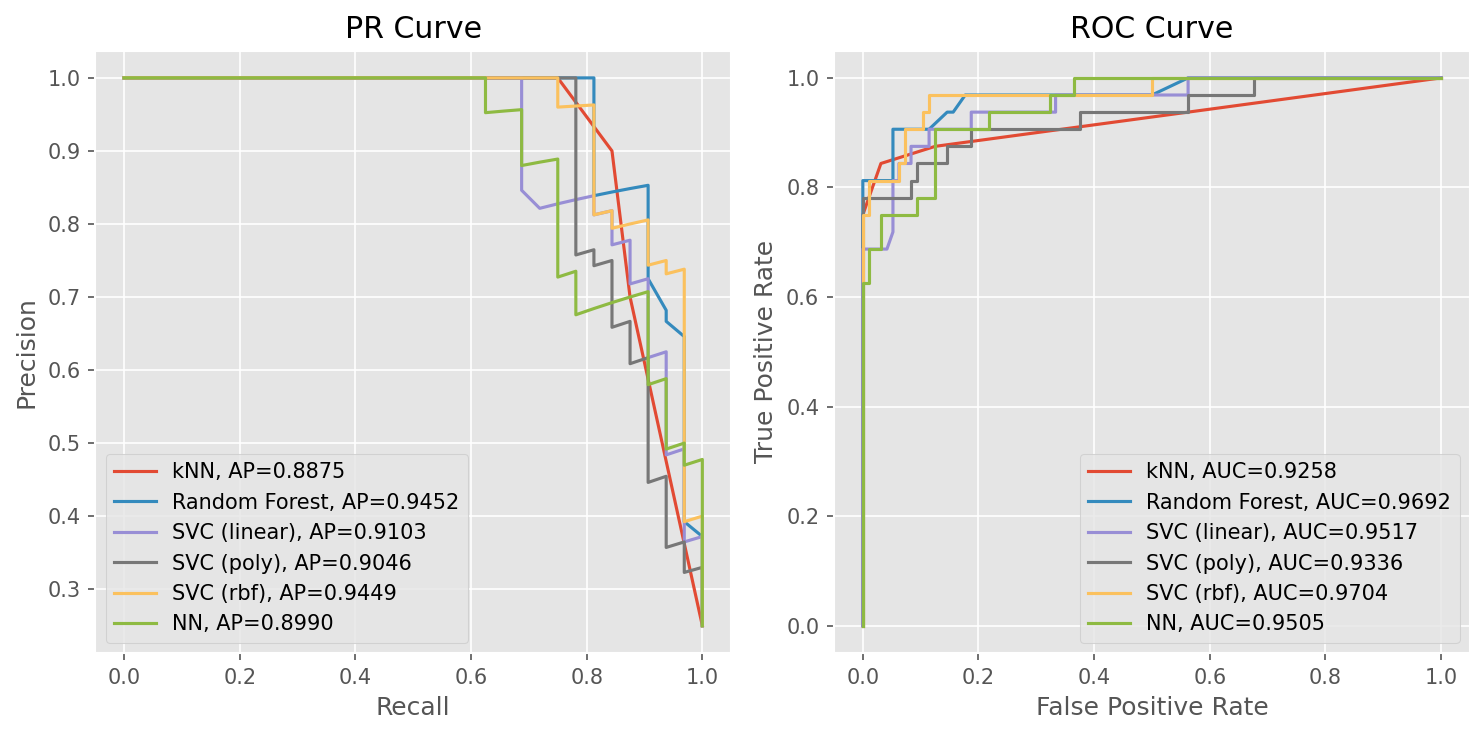

In [8]:
# Define checkpoints for different models on Hong Kong data
checkpoints = [
    {
        'data': hk_data,
        'labels': hk_labels,
        'architecture': 'kNN',
        'dataset': 'hk',
        'preprocessing': 'Y–J transformation',
        'pipeline': Pipeline([
            ('yj_transform', PowerTransformer()),
            ('knn', KNeighborsClassifier())
        ]),
        'legend': 'kNN'
    },
    {
        'data': hk_data,
        'labels': hk_labels,
        'architecture': 'Random Forest',
        'dataset': 'hk',
        'preprocessing': 'Y–J transformation',
        'pipeline': Pipeline([
            ('yj_transform', PowerTransformer()),
            ('rf', RandomForestClassifier(random_state=41))
        ]),
        'legend': 'Random Forest'
    },
    {
        'data': hk_data,
        'labels': hk_labels,
        'architecture': 'SVC (linear)',
        'dataset': 'hk',
        'preprocessing': 'Y–J transformation',
        'pipeline': Pipeline([
            ('yj_transform', PowerTransformer()),
            ('svc', SVC(kernel='linear', probability=True, random_state=41))
        ]),
        'legend': 'SVC (linear)'
    },
    {
        'data': hk_data,
        'labels': hk_labels,
        'architecture': 'SVC (poly)',
        'dataset': 'hk',
        'preprocessing': 'Y–J transformation',
        'pipeline': Pipeline([
            ('yj_transform', PowerTransformer()),
            ('svc', SVC(kernel='poly', probability=True, random_state=41))
        ]),
        'legend': 'SVC (poly)'
    },
    {
        'data': hk_data,
        'labels': hk_labels,
        'architecture': 'SVC (rbf)',
        'dataset': 'hk',
        'preprocessing': 'Y–J transformation',
        'pipeline': Pipeline([
            ('yj_transform', PowerTransformer()),
            ('svc', SVC(kernel='rbf', probability=True, random_state=41))
        ]),
        'legend': 'SVC (rbf)'
    },
    {
        'data': hk_data,
        'labels': hk_labels,
        'architecture': 'NN',
        'dataset': 'hk',
        'preprocessing': 'Y–J transformation',
        'pipeline': Pipeline([
            ('yj_transform', PowerTransformer()),
            ('nn', MLPClassifier(hidden_layer_sizes=(10,), activation='relu', solver='sgd', max_iter=10000, random_state=41))
        ]),
        'legend': 'NN'
    }
]

# Evaluate and display results
results_list = model_evaluator.evaluate_models(checkpoints)
display(pd.DataFrame(results_list))

# Plot curves
plotter.plot_pr_roc_curves(checkpoints)

## Hyperparameter Tuning on TC10 Data

In [10]:
# Train-Test Split with Stratification
X_train, X_test, y_train, y_test = train_test_split(
    tc10_data, tc10_labels, test_size=0.3, random_state=41, stratify=tc10_labels
)

# Define models and their parameter grids
models = {
    'SVC': {
        'pipeline': Pipeline([
            ('yj_transform', PowerTransformer()),
            ('svc', SVC(kernel='rbf', probability=True, random_state=41))
        ]),
        'param_grid': {
            'svc__C': np.logspace(-3, 3, num=7),
            'svc__gamma': ['scale', 'auto']
        }
    },
    'Random Forest': {
        'pipeline': Pipeline([
            ('yj_transform', PowerTransformer()),
            ('rf', RandomForestClassifier(random_state=41))
        ]),
        'param_grid': {
            'rf__n_estimators': [50, 100, 200],
            'rf__max_depth': [None, 10, 20]
        }
    }
}

# Initialize results list
results_list = []

# Loop through each model for hyperparameter tuning
for architecture, model_info in models.items():
    # Halving Grid search
    halving_grid = HalvingGridSearchCV(
        model_info['pipeline'], model_info['param_grid'], scoring='f1', n_jobs=-1
    )
    
    # Fit the model
    halving_grid.fit(X_train, y_train)
    
    # Use the model_evaluator to calculate metrics
    metrics = model_evaluator.train_test_evaluate(halving_grid.best_estimator_, X_test, y_test)
    metrics['Architecture'] = architecture
    metrics['Dataset'] = 'TC10'
    
    results_list.append(metrics)
    print(f"Best parameters for {architecture}: {halving_grid.best_params_}")

# Display results
display(pd.DataFrame(results_list))

Best parameters for SVC: {'svc__C': np.float64(100.0), 'svc__gamma': 'scale'}
Best parameters for Random Forest: {'rf__max_depth': 20, 'rf__n_estimators': 50}


,accuracy,roc_auc,precision,recall,f1,average_precision,Architecture,Dataset
0,0.8125,0.9091,0.9000,0.8182,0.8571,0.9632,SVC,TC10
1,0.8750,0.9818,1.0000,0.8182,0.9000,0.9860,Random Forest,TC10
